## GRAY IMAGES

In [ ]:
from PIL import Image
import pandas as pd
import os

In [ ]:
anot_path = "./data/attention.csv"
images_path = "./data/datasets/"

gray_images_path = "./data/grayimage"

In [ ]:
df = pd.read_csv(anot_path)
df.columns = ['filename', 'score']
df['score'].value_counts()

In [ ]:
save_path = "data/gray_data.csv"

data = {
    'width': [],
    'height': [],
    'file_path': [],
    'score': []
}

if not os.path.exists(gray_images_path):
    os.makedirs(gray_images_path)

for item, score in zip(df['filename'].tolist(), df['score'].tolist()):
    file_path = os.path.join(images_path, item)
    gray_path = os.path.join(gray_images_path, item)

    img = Image.open(file_path).convert("L")
    
    img.save(gray_path)
    
    data['width'].append(img.size[0])
    data['height'].append(img.size[1])
    data['file_path'].append(gray_path)
    data['score'].append(score)

In [ ]:
pd.DataFrame(data).to_csv(save_path, index=False)

## BLUR CANNY CONTOUR 

In [ ]:
import pandas as pd
from PIL import Image
import random
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

# anomali data 69, 5, 36
# rd_idx = 5

file_path = "data/gray_data.csv"
df = pd.read_csv(file_path)

def Proccess(df = df, idx = None, biar_rapih = False):
    if idx == None:
        idx = random.randint(0, len(df['file_path'].tolist()))
    
    sample_image_name = df['file_path'].tolist()[idx]
    score = df['score'].tolist()[idx]

    img_np = np.array(Image.open(sample_image_name))
    
    if not biar_rapih:
        # gausah didebug ini [biar apa biarin | pusing gw njir ngeliatnya]
        print(f"image idx: {idx} | score: {score} | filename: {sample_image_name}")
        print(f"image size: {img_np.shape}")

    blank = np.zeros(shape=img_np.shape, dtype='uint8')

    gaussBlur = cv.GaussianBlur(img_np, (175, 175), 0.3)
    canny = cv.Canny(gaussBlur, 100, 100)

    _, tresh = cv.threshold(img_np, 125, 255, cv.THRESH_BINARY)
    _, blurtresh = cv.threshold(gaussBlur, 125, 255, cv.THRESH_BINARY)

    contours, _ = cv.findContours(canny, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
    cv.drawContours(blank, contours, -1, 255, 1)
    
    images = [img_np, gaussBlur, canny, tresh, blank]
    titles = ['Gray', 'Gaussian Blur', 'Canny', 'Threshold', 'Contours Drawn']
    
    return images, titles

def ShowImage(images, titles):
    
    plt.figure(figsize=(15, 8))

    for i in range(len(images)):
        plt.subplot(2, 3, i + 1)  # 2 baris, 3 kolom
        if len(images[i].shape) == 2:  # grayscale
            plt.imshow(images[i], cmap='gray')
        else:  # RGB image
            plt.imshow(cv.cvtColor(images[i], cv.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [70]:
max_w = max(df['width'].tolist())
min_w = min(df['width'].tolist())

max_h = max(df['height'].tolist())
min_h = min(df['height'].tolist())

print(f"max-width: {max_w} | min-width: {min_w} | max-height: {max_h} | min-height: {min_h}")

max-width: 1080 | min-width: 102 | max-height: 526 | min-height: 50


image idx: 13 | score: 1 | filename: ./data/grayimage\15.png
image size: (250, 766)


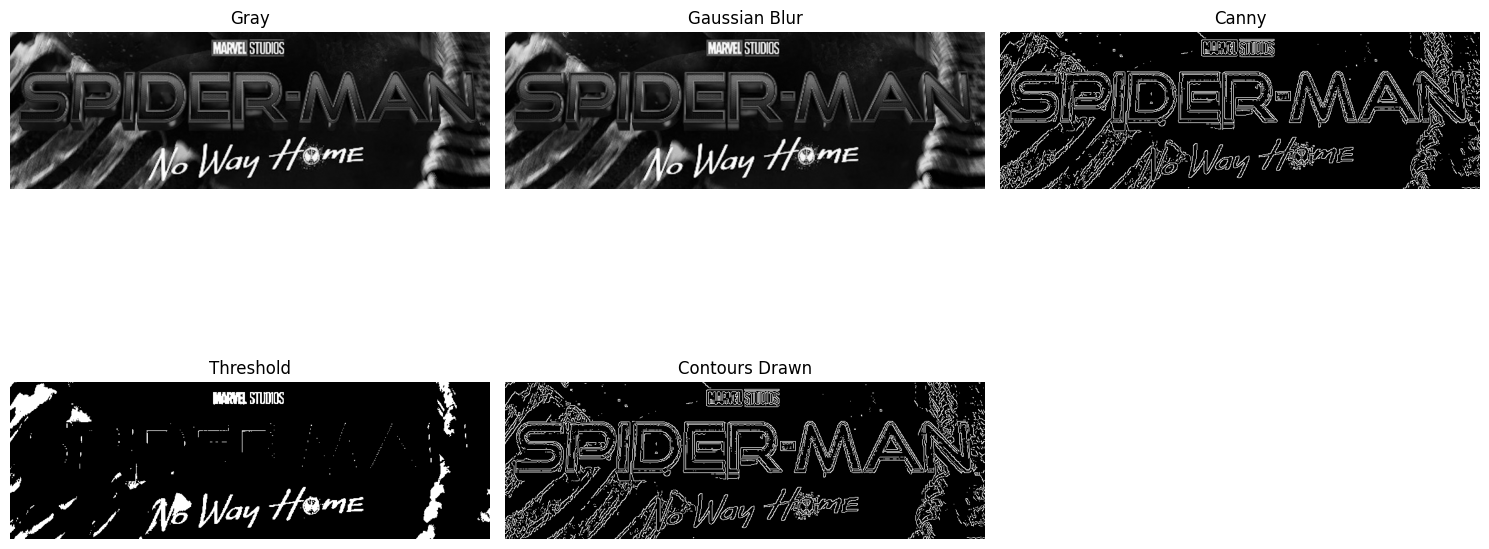

image idx: 13 | score: 1 | filename: ./data/grayimage\15.png
image size: (250, 766)


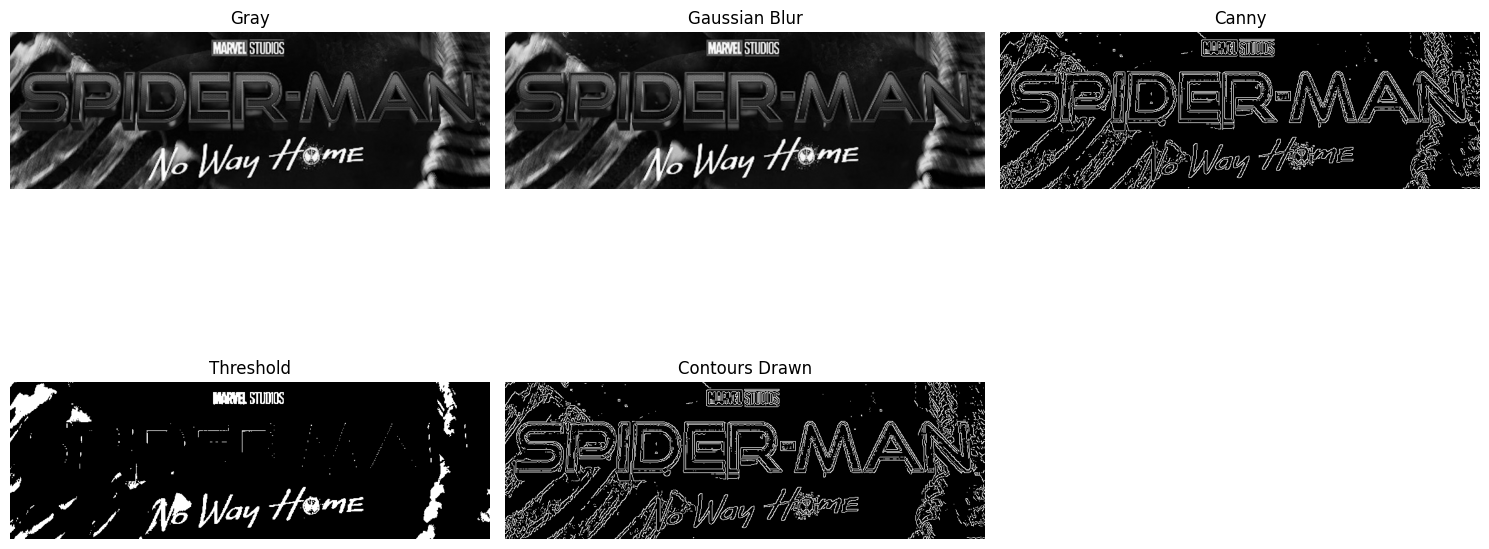

image idx: 13 | score: 1 | filename: ./data/grayimage\15.png
image size: (250, 766)


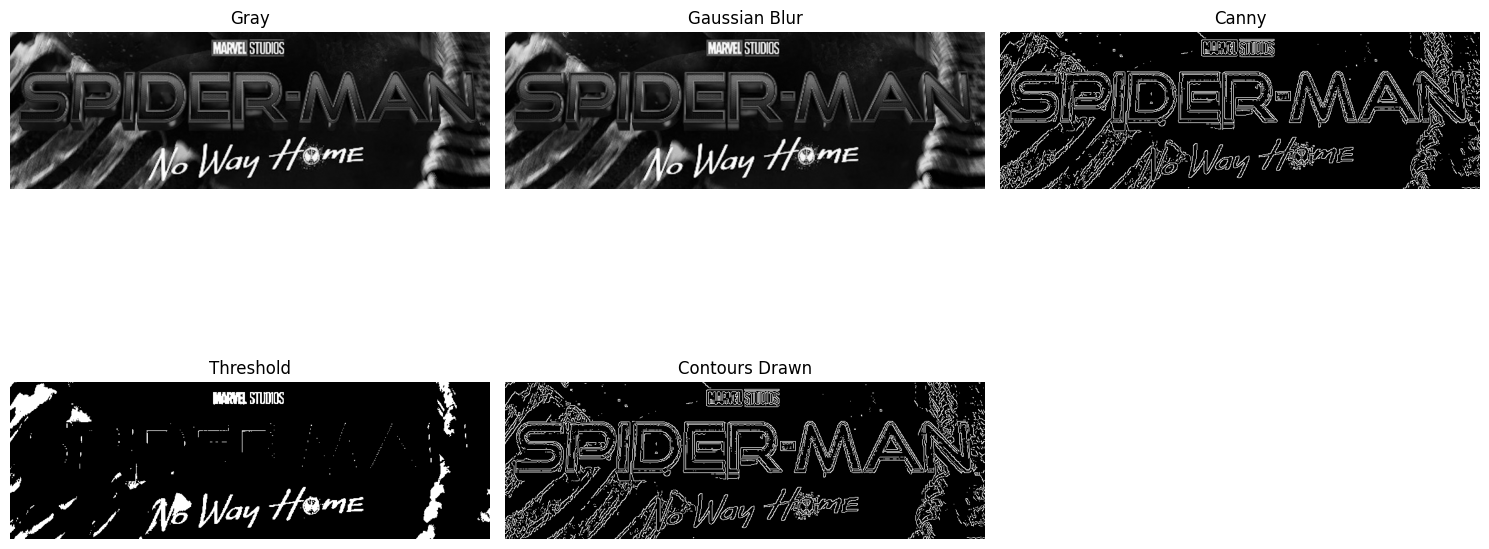

image idx: 13 | score: 1 | filename: ./data/grayimage\15.png
image size: (250, 766)


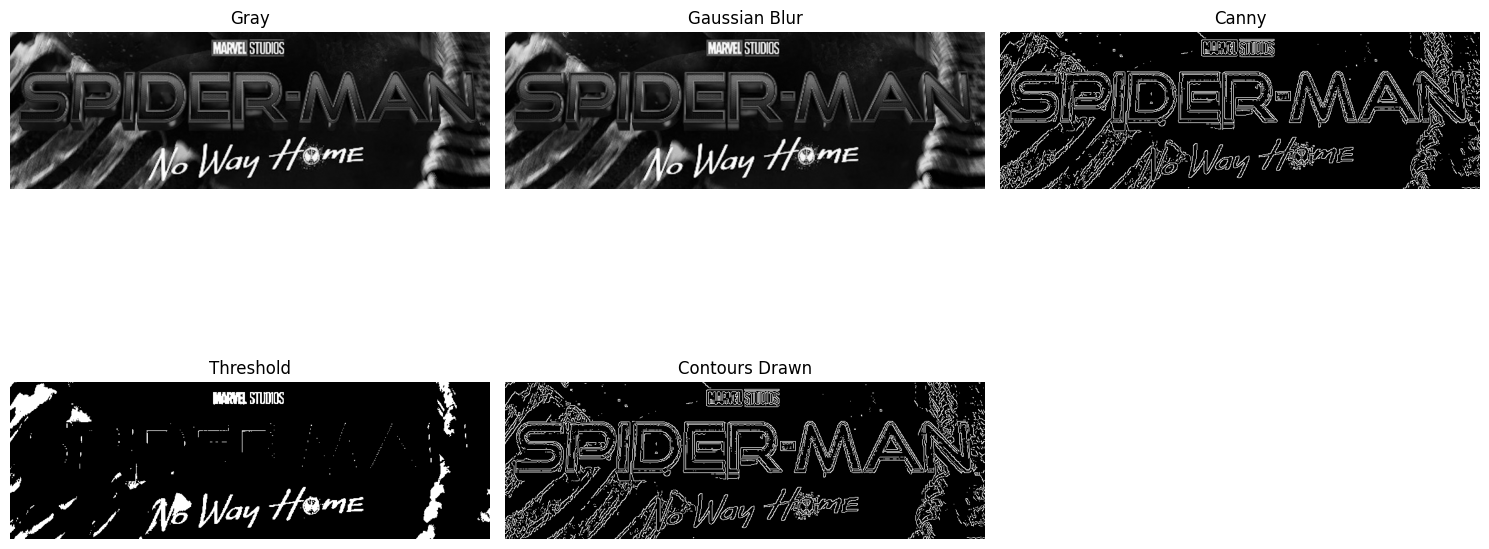

image idx: 13 | score: 1 | filename: ./data/grayimage\15.png
image size: (250, 766)


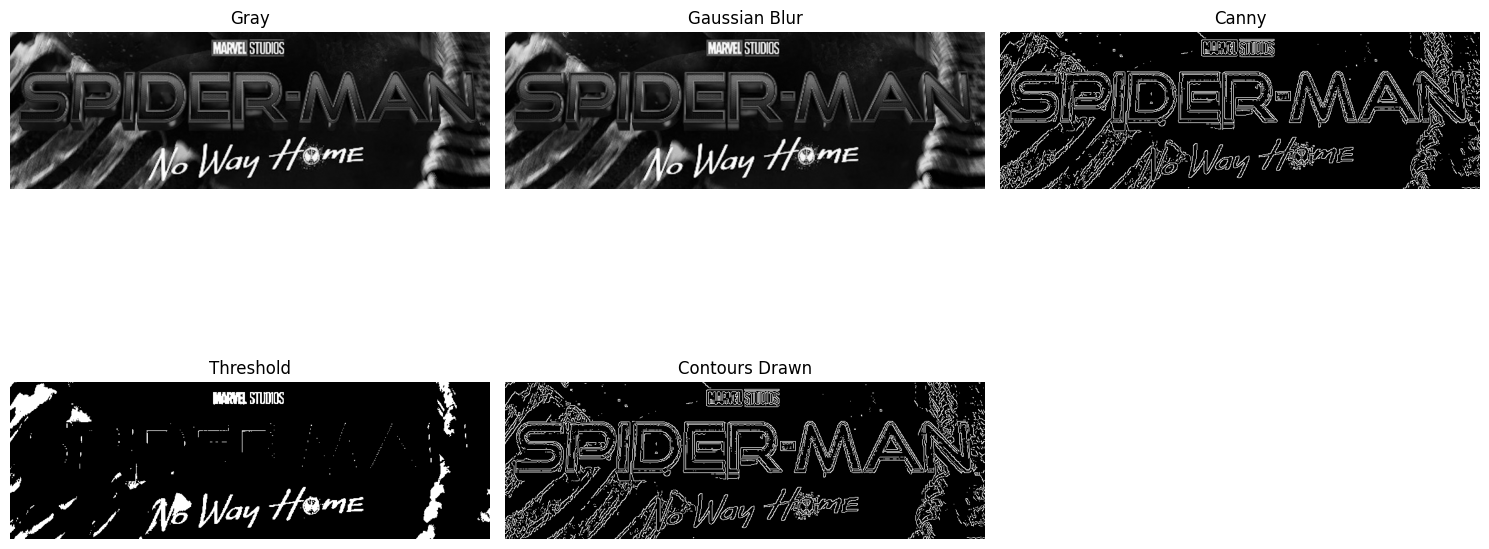

In [71]:
for i in range(5):
    images, titles = Proccess()
    ShowImage(images, titles)

## LOAD DATA INTO NDARRAY

In [ ]:
df.describe()

# mean width = 624
# mean height = 208

# biar 2^ pake width = 512 (2**9)
# biar 2^ pake height = 256 (2**8)

,width,height,score
count,198.000000,198.000000,198.000000
mean,624.005051,208.671717,2.464646
std,225.453530,99.118338,1.398426
min,102.000000,50.000000,0.000000
25%,468.500000,131.000000,1.000000
50%,646.000000,200.000000,3.000000
75%,795.500000,259.500000,4.000000
max,1080.000000,526.000000,5.000000


In [57]:
def resize(np_img, w = 512, h = 256):
    return cv.resize(np_img, dsize=(w, h), interpolation=cv.INTER_LINEAR)

In [72]:
gray_np = [] # gray images
gaussBlur_np = []
canny_np = []
tresh_np = []
contour_np = []

# load to array
for i in range(len(df['file_path'].tolist())):
    '''
    images = [
        img_np, gaussBlur, canny, tresh, blank]
        [gray, gaussblur(gray), canny(gray), tresh(gray), contour(grey)
    ]
    '''
    
    images, _ = Proccess(idx=i, biar_rapih=True)
    # print(type(resize(images[0])))
    # print(resize(images[0]))
    # print(resize(images[0]).shape)
    # break
    gray_np.append(resize(images[0]))
    gaussBlur_np.append(resize(images[1]))
    canny_np.append(resize(images[2]))
    tresh_np.append(resize(images[3]))
    contour_np.append(resize(images[4]))

# transform into 
gray_np = np.array(gray_np)
gaussBlur_np = np.array(gaussBlur_np)
canny_np = np.array(canny_np)
tresh_np = np.array(tresh_np)
contour_np = np.array(contour_np)

In [ ]:
print(gray_np.shape, gaussBlur_np.shape, canny_np.shape, tresh_np.shape, contour_np.shape)

# pake dah mau pake yang mana

(198, 256, 512) (198, 256, 512) (198, 256, 512) (198, 256, 512) (198, 256, 512)


## TRY ML MODEL [alex]

In [ ]:
X = 